In [83]:
%config IPCompleter.greedy=True

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.datasets, sklearn.model_selection
from progressbar import progressbar

At the end of the previous notebook, I briefly showed one-vs-rest classification technique and normalization of the distribution. We may put this normalization after the sigmoid activation functions - that exactly, what softmax is suppose to do.

# Softmax

Formally, we may define the softmax as follow:

$$
softmax(\pmb{x})_i = \frac{e^{x_i}}{\sum_k e^{x_k}}
$$

In other word, we apply exponential to each input of the softmax and then normalize the probability distribution.

Note that softmax is just a generalization of the sigmoid activation.

$$
softmax(x, 0) = \frac{e^x}{e^x + e^0} = \frac{e^x}{e^x + 1} \cdot \frac{e^{-x}}{e^{-x}} = \frac{e^{x-x}}{e^{x-x} + e^{-x}} = \frac{e^0}{e^0 + e^{-x}} = \frac{1}{1+e^{-x}} = \sigma(x)
$$

Now, when we have the formula, it is easy to implement the sigmoid in numpy.

In [2]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

But why to bother with sigmoid and not just normalize the outputs of sigmoids? It turns out, we may get better numerical properties if we join sigmoids and normalization into one "layer". Thanks to the following equation.

$$
softmax(\pmb{x}+c)_i=\frac{e^{x_i+c}}{\sum_k e^{x_k+c}} = \frac{e^c}{e^c} \cdot \frac{e^{x_i}}{\sum_k e^{x_k}} = softmax(\pmb{x})_i
$$

The danger in the softmax are the exponents, when the divisor can become too big for float values and as a result become infinity. However, we may set $c=max(\pmb{x})$ and as all the scalars are negative or zero, there would be no overflow. Cases, where the divisor become zero are much more unlikely and even if some scalars are so small, that they are round to zero because of the float precision, it doesn't matter for use to distinguish between their actual value and zero. 

This way, we have our modified softmax function.

In [3]:
def softmax(x):
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

## Gradient

Before we move on, we need to know how to compute gradient. That is not that easy as with softmax, as we have multiple inputs and multiple outputs. You may try it by hand, if you wish.

$$
\frac{\partial softmax(\pmb{x})_i}{\partial x_j} = \frac{\partial \frac{e^{x_i}}{\sum_k e^{x_k}}}{\partial x_j}
$$

There are three indices! Moreover, this is derivative only in respect to one input variable. We need to compute gradient of every output in respect to every input. I don't want to dig too much into the math, you can see [[1]](#Bibliography) if you wanna know more. In the end, the gradient pops out, so we may implement it.

$$
\frac{\partial softmax(\pmb{x})_i}{\partial x_j} = 
\begin{cases}
    softmax(\pmb{x})_j - softmax(\pmb{x})_j \cdot softmax(\pmb{x})_i & \text{if } i = j \\
    0 - softmax(\pmb{x})_j \cdot softmax(\pmb{x})_i & \text{if } i \neq j \\
\end{cases}
$$

You may notice something strange - the gradient is table. Remember, we compute gradient of each output in respect to each input. That need's to be a table. But we want only gradients in respect to the inputs - we need to sum the gradients over the outputs, the same way, as we sum gradients of multiple examples. I won't show the implementation just yet, as I believe it would be more helpfull to view the code and the explanation in bigger picture.

I mentioned **layer** a while ago. The fact is, the softmax is really a layer, how we understand them in the context of neural networks. We will implement our first simple neural networks in the very next notebook. It tooks us eight notebooks, but we finally have enough knowledge to do that. However, we need some refactoring of the code before we can do that.

# Refactoring

Let's start with the **layer** implementation itself. Maybe I should tell first, what the layer is. During the neural network training (we may thing about the logistic regression as about a simple neural network) we are exploiting the chain rule. You may remember from the school the chain rule.

$$
\frac{\partial f(g(h(x)))}{\partial x} = \frac{\partial f(g(h(x)))}{\partial g(h(x))} \cdot \frac{\partial g(h(x))}{\partial h(x)} \cdot \frac{\partial h(x)}{\partial x}
$$

This is not different from our model, remember that loss of logistic regression was written as:

$$
\mathcal{L}(\sigma(\pmb{x}\pmb{w})
$$

And we need to update the weights.

$$
\frac{\mathcal{L}}{\partial \pmb{w}} = \frac{\partial \mathcal{L}}{\partial \sigma} \cdot \frac{\partial \sigma}{\partial \pmb{x}\pmb{w}} \cdot \frac{\partial \pmb{x}\pmb{w}}{\partial \pmb{w}}
$$

Each part of the gradient will be one layer. We will use the same layers for neural nerworks later on. We already implemented some - for example the loss function.

In [2]:
class CategoricalCrossEntropyLoss:
    def __call__(self, target, predicted):
        indices = np.arange(len(target))
        return -np.log(np.maximum(predicted[indices,target], 1e-15))
    
    def gradient(self, target, predicted):
        grad = np.zeros((len(target), 10))
        indices = np.arange(len(target))
        grad[indices,target] = -1 / predicted[indices,target]
        return grad

Notice, that the layer accepts output of the previous layer (in this case in shape `(batchsize, classes)`) and it returns it's gradient in respect to it's input - again in the shape `(batchsize,classes`).

We may use the same approach - let's now implement the sigmoid layer. It takes inputs and apply sigmoid activation function on each of it. It is simple to implement it right away, but there is one problem. If you carefully look at the chain rule, the gradients are multiplied by the gradients of the following layer. In other word, by computing gradient of the sigmoid, we need to compute this:

$$
\frac{\mathcal{L}}{\partial \pmb{w}} = \frac{\partial \mathcal{L}}{\partial \sigma} \cdot \frac{\partial \sigma}{\partial \pmb{x}\pmb{w}}
$$

As a result, the gradient function doesn't accept only layer's input, but gradient from the following layer as well. Now we may implement the sigmoid activation layer.

In [3]:
class SigmoidLayer:
    def __call__(self, inputs):
        return 1 / (1 + np.exp(-inputs))
    
    def gradient(self, inputs, gradients):
        outputs = self(inputs)
        my_gradient = outputs * (1 - outputs)
        return my_gradient * gradients

Now let's look at the softmax layer. This case is a bit complicated, as the gradient is not a vector, but a table. In general, most layers that have multiple inputs and multiple outputs will generate gradient table (note that for each example), as it needs to compute gradient of each output in respect to each input. The sigmoid activation layer, and activation layers in general, are exceptions. Each output corresponds to one input and as such the inputs doesn't interfere. You may look at it from the other side, the gradient of output $i$ in respect to input $j$ is zero if $i \neq j$. That results in table full of zeros except diagonals.

But let's return back to the softmax layer. We already implemented it above, but only for a single example. We need to generalize it for batch of examples. Only thing we need to make sure about is to divide inputs in the correct axis, the generalization is simple.

In [53]:
def batch_softmax(inputs):
    inputs = inputs - np.max(inputs)
    return np.exp(inputs) / np.sum(np.exp(inputs), axis=-1)[:,np.newaxis]

Now let's look at the gradient, the formula is above. It would be simpler to rewrite it in the matrix form, so we may implement it in the numpy. Notice that the only difference is on the diagonal (when $i - j$) where we add additional term. In a matrix notation it results in following equation (as you may see in [[1]](#Bibliography) as well):

$$
\frac{\partial softmax(\pmb{x})}{\partial \pmb{x}} = 
\begin{pmatrix}
o_1 & 0 & \dots & 0 \\ 
0 & o_2 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & o_k
\end{pmatrix}
-
\begin{pmatrix}
o_1 o_1 & o_1 o_2 & \dots & o_1 o_k \\ 
o_2 o_1 & o_2 o_2 o_2 & \dots & o_2 o_k \\
\vdots & \vdots & \ddots & \vdots \\
o_k o_1 & o_k o_2 & \dots & o_k o_k
\end{pmatrix}
$$

The vector $\pmb{o}$ is the output of softmax $softmax(\pmb{x})=\pmb{o}$. Notice the symetry of the matrices, we will exploit it in a minute. If we have variable `outputs` thats contains the output of the softmax function, we may implement the matrix notations to the numpy very simply.

In [55]:
def softmax_gradient(inputs):
    outputs = softmax(inputs)
    return np.diag(outputs) - outputs @ outputs

There are three things we need to deal before we may continue. First problem is the matrix of the gradient - remember we want the gradient in respect to the inputs of the softmax, so we may pass it to the previous layer (remember the chain rule I showed you before). Now we have a matrix - gradient of each output in respect to each input. All we need to is to sum up the gradients over the outputs. As a result, we get a vector, that represents the "acumulated" gradient in respect to each input. I may formulate it in other way around - we receive gradient of how much we want to shift each output. Each output tells us, how much it wants to shift it's input so the output is shifted the corrrect way (and therefore we get the matrix). In the end, we want to satisfy all the outputs - we sum the effect of each output on the inputs and as a result, we get the vector that represents the gradient in respect to the inputs.

In [56]:
def softmax_gradient(inputs):
    outputs = softmax(inputs)
    return np.sum(np.diag(outputs) - outputs @ outputs, axis=1)

Second problem that I didn't account for yet is the gradient from the next layer. Once again, remember the chain rule. The gradient of the softmax need's to be multiplied with the gradient of the following layer (for example the cross entropy loss). We just need to make sure, we multiply the gradient along a correct axis. We think about the matrix above as a gradient of outputs in respect to the inputs, in other word at index $i,j$ is gradient of output $j$ in respect to input $i$, we need to multiply each row and then sum the gradients over columns. As I pointed out, the matrix is in this case symetric and as such doesn't matter in which way we multiply it - we just need to make sure, we multiply it in different axis that we are summing it later.

In [57]:
def softmax_gradient(inputs, gradients):
    outputs = softmax(inputs)
    my_gradient = np.diag(outputs) - outputs @ outputs
    return np.sum(gradients[np.newaxis,:] * my_gradient, axis=1)

Finally, the third and the last problem - we didn't count with the batches. The code above won't work for multiple examples, as with softmax, we need to generalize it. We can't rely on vector and matrix multiplication, as we have higher dimensional objects. The code is bellow and it get's a bit nasty, I add comments about the shapes of numpy arrays, so you may better understand it. I wish I could write it more readable, but this is as far as I could get.

There are two more attributes - `params` and `grads`. We don't need them yet and I will talk about them in a while, for now just ignore them.

In [61]:
class SoftmaxLayer:
    def __init__(self):
        self.params = []
        self.grads = []
    
    def __call__(self, inputs):
        inputs = inputs - np.max(inputs)
        return np.exp(inputs) / np.sum(np.exp(inputs), axis=-1)[:,np.newaxis]
    
    def gradient(self, inputs, gradients):
        outputs = self(inputs)  # examples, classes
        examples, classes = outputs.shape
        diag = np.zeros((examples, classes, classes))  # examples, classes, classes
        diag[:, np.arange(classes), np.arange(classes)] = outputs # set the diagonal of each example
        my_gradient = diag - outputs[:,:,np.newaxis] * outputs[:,np.newaxis,:]  # examples, classes, classes
        return np.sum(gradients[:,np.newaxis,:] * my_gradient, axis=2) # examples, classes

# Dense layer

Now it is time for our last layer. If you remember, the logistic regression had vector of weights, that was multiplied with the example vector (or matrix when we had batch). For the one-vs-rest approach we had multiple logistic regressions and when we were processing the examples, we need to pass it through every neuron. As turns out, we can join the weights of all the neurons together into the weights matrix.

$$
\mathbb{X}\mathbb{W}
$$

Moreover, we may export the bias explicitly and get rid of the additional $1$ that we needed to pad the examples with. As a result, we may express the whole loss of multiclass logistic regression in the following formula.

$$
\text{CrossEntropy}(\text{softmax}(\mathbb{X}\mathbb{W}+\mathbb{b}))
$$

The layer, that is responsible for the linear kombination (the $\mathbb{X}\mathbb{W}+\mathbb{b}$) is called **dense layer** or **fully-connected layer**. That is exactly what we will now focus on.

We have the formula for calculating the output of the layer. Now we need to compute the gradient. As we have only linearities, the gradients are simple as well.

$$
\frac{\partial \mathbb{X}\mathbb{W}+\mathbb{b}}{\partial \mathbb{W}} = \mathbb{X}^T \\
\frac{\partial \mathbb{X}\mathbb{W}+\mathbb{b}}{\partial \mathbb{b}} = sign(\mathbb{b}) \\
\frac{\partial \mathbb{X}\mathbb{W}+\mathbb{b}}{\partial \mathbb{X}} = \mathbb{W}^T + sign(\mathbb{b})
$$

But now we have three gradients - in respect to weights, to bias and to inputs. All previous layers don't have learning parameters, so we need only derivatives in respect to the inputs. Now, we need also derivatives in respect to the weights and bias. Thats why I defined the `params` and `grads` attributes. Attribute `params` is list of learnable parameters and `grads` attributes contains gradients of these parameters. We will use them during the optimization process.

From the implementation of view, both the forward and backward pass is very simple, we just need to make sure the axis align. As with the softmax, I put comments into the implementation about the resulting shape of the variable. Let's see it.

In [70]:
class DenseLayer:
    def __init__(self,inputs, outputs, random_seed=None):
        self._random_state = np.random.RandomState(random_seed)
        self._W = self._random_state.uniform(-2,2,size=(inputs, outputs))
        self._b = self._random_state.uniform(-2,2,size=(outputs,))
        self.params = [self._W, self._b]
        self.grads = [np.zeros_like(self._W), np.zeros_like(self._b)]
    
    def __call__(self, inputs):
        return inputs @ self._W + self._b[np.newaxis,:]
    
    def gradient(self, inputs, gradients):
        # gradient in respect to W
        w_grad = inputs[:,:,np.newaxis] * gradients[:,np.newaxis,:]  # examples, inputs, outputs
        np.add(self.grads[0], np.sum(w_grad, axis=0), out=self.grads[0])  # inputs, outputs
        # gradient in respect to b
        b_grad = gradients  # examples, outputs
        np.add(self.grads[1], np.sum(b_grad, axis=0), out=self.grads[1])  # outputs
        # gradient in respect to inputs
        in_grad = self._W[np.newaxis,:,:] * gradients[:,np.newaxis,:] + np.sign(self._b)[np.newaxis, np.newaxis, :]  # examples, inputs, outputs
        return np.sum(in_grad, axis=2) # examples, inputs

There is small space for a optimization. We may tell numpy to use existing memory instead of creating ita gain and again at every pass. This optimization comes handy, as the dense layer is the most computationally demanding layer. The following code is equivalent of the previous one, but uses cache memory in the size of *(examples,inputs,outputs)* to pseed up the computation.

In [139]:
class DenseLayer:
    def __init__(self,inputs, outputs, random_seed=None):
        self._random_state = np.random.RandomState(random_seed)
        self._W = self._random_state.uniform(-2,2,size=(inputs, outputs))
        self._b = self._random_state.uniform(-2,2,size=(outputs,))
        self.params = [self._W, self._b]
        self.grads = [np.zeros_like(self._W), np.zeros_like(self._b)]
        self._cache = None
    
    def __call__(self, inputs):
        return inputs @ self._W + self._b[np.newaxis,:]
    
    def gradient(self, inputs, gradients):
        # create the cache
        if self._cache is None or self._cache.shape[0] != inputs.shape[0]:
            self._cache = np.ndarray((inputs.shape[0],inputs.shape[1], gradients.shape[1]))
        # gradient in respect to W
        w_grad = np.multiply(inputs[:,:,np.newaxis], gradients[:,np.newaxis,:], out=self._cache)  # examples, inputs, outputs
        np.add(self.grads[0], np.sum(w_grad, axis=0), out=self.grads[0])  # inputs, outputs
        # gradient in respect to b
        b_grad = gradients  # examples, outputs
        np.add(self.grads[1], np.sum(b_grad, axis=0), out=self.grads[1])  # outputs
        # gradient in respect to inputs
        in_grad = np.multiply(self._W[np.newaxis,:,:], gradients[:,np.newaxis,:], out=self._cache)  # examples, inputs, outputs
        in_grad = np.add(in_grad, np.sign(self._b)[np.newaxis, np.newaxis, :], out=self._cache)  # examples, inputs, outputs
        return np.sum(in_grad, axis=2) # examples, inputs

Now we have all the layers we need. Last thing we need to refactor is the gradient descent algorithm.

# Gradient descent optimizer

This refactoring will be very fast. We still don't have the `Model` class, but I may tell you in advance that it would have `layers` property, that would be list of individual layers. As each layer has `params` and `grads` attributes (thats why they are even in the softmax layer), the optimizer can use that. The optimizer will have `optim` method, that accepts the model and perform one step of the gradient descent algorithm.

We will have better optimizers later on, that's why I wanted to export it outside of the model itself. Our gradient descent algorithm can looks like this:

In [126]:
class SGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def optim(self, model):
        for layer in model.layers:
            for params, grad in zip(layer.params, layer.grads):
                np.add(params, - self.learning_rate * grad, out=params)

# Model

We are fininish. Now we will define `Model` class, that would represent the model itself. It will contain layers in the `layers` attribute, as I mentioned before. Other than that, It will have standard methods we have seen in the logistic regression.

The prediction is done layer by layer, the code can look something like this:


In [ ]:
zero_grad()
current_grad = loss.gradient(batch_target, outputs[-1])
for layer, layer_input in zip(self.layers[::-1], outputs[-2::-1]):
    current_grad = layer.gradient(layer_input, current_grad)

We will remember the outputs of layers (there are inputs to following layers) in the `outputs` variable and use them during backpropagation phase. Firstly, we will compute the gradient of the loss and then pass it to `gradient` method of the last layer. The gradient will propagate through the layers (from the last to the first layer) untill we have gradients of weights. As our code accumulates the gradients of the weights (notice the `np.add` call), we need to zero the gradients first. The code can look simmilar to this: 

In [ ]:
self.zero_grad()
current_grad = loss.gradient(batch_target, outputs[-1])
for layer, layer_input in zip(self.layers[::-1], outputs[-2::-1]):
    current_grad = layer.gradient(layer_input, current_grad)

In the end, we call our optimizer to update the weights. Rest of the code should be strighforward, as it is just copied from the previous notebooks.

In [140]:
class MulticlassLogisticRegression:
    def __init__(self, input_dim, classes, loss, metrices = [], random_seed = None):
        self._rand = np.random.RandomState(random_seed);
        self.loss = loss
        self.metrices = metrices
        self.layers = [
            DenseLayer(input_dim, classes, self._rand.randint(100000)),
            SoftmaxLayer()
        ]
        
    def zero_grad(self):
        for layer in self.layers:
            for grad in layer.grads:
                grad.fill(0)
    
    def fit(self, X, y, optimizer, Xtest=None, ytest=None, epochs=100, batch_size=32, progress=False):
        # get how many data we have
        n_train_data = len(X)
        n_test_data = 1 if ytest is None else len(ytest)
        # store gradients and losses
        train_losses = np.zeros((epochs,))
        test_losses = np.zeros((epochs,))
        train_metrices = np.zeros((len(self.metrices), epochs))
        test_metrices = np.zeros((len(self.metrices), epochs))
        # decide whatever to log progress
        epoch_counter = progressbar(range(epochs)) if progress else range(epochs)
        # Learning
        outputs = [None] * (len(self.layers) + 1)
        for epoch in epoch_counter:
            # shuffle the data
            permutation = self._rand.permutation(n_train_data)
            # for each batch
            for batch_start in range(0, n_train_data, batch_size):
                # get batch
                batch_data = X[permutation[batch_start:batch_start+batch_size]]
                batch_target = y[permutation[batch_start:batch_start+batch_size]]
                # forward pass
                outputs[0] = batch_data
                for layer, i in zip(self.layers, range(len(self.layers))):
                    outputs[i+1] = layer(outputs[i])
                # backward pass
                self.zero_grad()
                current_grad = self.loss.gradient(batch_target, outputs[-1])
                for layer, layer_input in zip(self.layers[::-1], outputs[-2::-1]):
                    current_grad = layer.gradient(layer_input, current_grad)
                # update the weights
                optimizer.optim(self)
                # store loss
                train_losses[epoch] += np.sum(self.loss(batch_target, outputs[-1]))
                # compute the metrices
                for metric in self.metrices:
                    metric(batch_target, outputs[-1])
            # store train metrices
            for num_metric, metric in enumerate(self.metrices):
                train_metrices[num_metric, epoch] = metric.summary()
                
            # evaluate on the test set
            if Xtest is not None and ytest is not None:
                # for each batch
                for batch_start in range(0, n_test_data, batch_size):
                    # get batch
                    batch_data = Xtest[batch_start:batch_start+ batch_size]
                    batch_target = ytest[batch_start:batch_start + batch_size]
                    # predict the data
                    prediction = self.predict(batch_data)
                    # store loss
                    test_losses[epoch] += np.sum(self.loss(batch_target, prediction))
                    # compute the metrices
                    for metric in self.metrices:
                        metric(batch_target, prediction)
                # store test metrices
                for num_metric, metric in enumerate(self.metrices):
                    test_metrices[num_metric, epoch] = metric.summary()
          
        results = {
            "train_loss": train_losses / n_train_data, 
            "test_loss": test_losses / n_test_data,      
        }
        results.update({f"train_{metric.name}": train_metrices[num_metric] for num_metric in range(len(self.metrices))})
        results.update({f"test_{metric.name}": test_metrices[num_metric] for num_metric in range(len(self.metrices))})
        return results
    
    def predict(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

I had some doubts about which parameters should be in constructor and which one in the `fit` method, so don't be afraid of the differences with the model in the previous notebook. 

# Training

Now let's put out model in action. First we need the data. Notice that I don't pad them by 1 this time - the bias term in the dense network cares of it.

In [130]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
y, X = y.astype(int), X.reshape(-1, 784)
X[X < 128] = 0
X[X > 0] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=47)

We will also need our accuracy metric. As we modified the output of the model a little bit (we return probability distribution instead of class), the accuracy  is a bit different than in the previous notebook. I ass `np.argmax` call to get predicted class.

In [131]:
class AccuracyMetric:
    def __init__(self, name=None):
        self.name = name or "accuracy"
        self.correct = 0
        self.num = 0
    def __call__(self, target, predicted):
        self.correct += np.sum(np.argmax(predicted,axis=1) == target)
        self.num += len(target)
    def summary(self):
        acc = self.correct / self.num
        self.correct = 0
        self.num = 0
        return acc

Now we may create the optimizer, model and train it.

In [141]:
optimizer = SGD(learning_rate=0.001)
model = MulticlassLogisticRegression(784, 10, loss=CategoricalCrossEntropyLoss(), metrices=[AccuracyMetric()], random_seed=42)
result = model.fit(train_data, train_target, optimizer, test_data, test_target, epochs=400, batch_size=128, progress=True)

100% (400 of 400) |######################| Elapsed Time: 0:26:44 Time:  0:26:44


If you remember, the running time of 10 logistic regression were around 11 minutes in the previous notebook. It may be surprising the 26 minutes in this case. The fact is, that we compute something, we don't need to right now. When we call the `gradient` method on the dense layer, it returns the gradient for the previous layer - but we don't have any. This computation is the most demanding one and accounts for the additional 15 minutes of the training. I could just ignore it and do not implement it, but we are going to need it in the following notebook.

Let's now look at the results.

In [142]:
print(f"Train accuracy: {result['train_accuracy'][-1]}, Test accuracy: {result['test_accuracy'][-1]}")

Train accuracy: 0.9333673469387755, Test accuracy: 0.9088571428571428


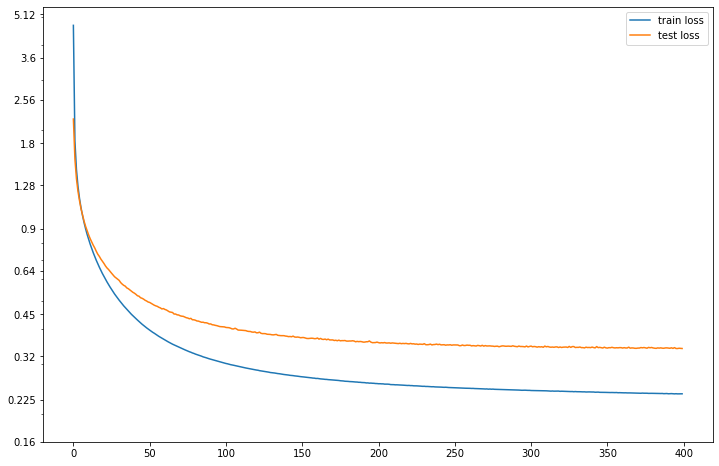

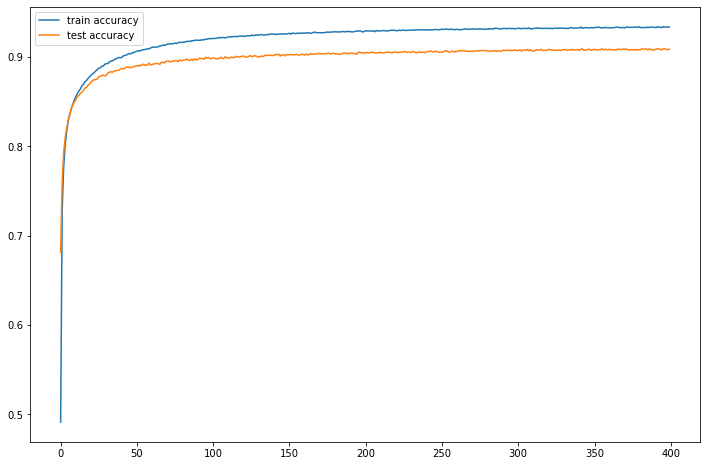

In [145]:
plt.figure(figsize=(12,8))
plt.plot(result['train_loss'], label="train loss")
plt.plot(result['test_loss'], label="test loss")
plt.yscale('log')
ticks = [0.16, 0.225, 0.32, 0.45, 0.64, 0.9, 1.28, 1.8, 2.56, 3.6, 5.12]
plt.yticks(ticks=ticks, labels=ticks)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(result['train_accuracy'], label="train accuracy")
plt.plot(result['test_accuracy'], label="test accuracy")
plt.legend()
plt.show()

As we may see, the accuracies are close to the one-vs-rest approach we used in the last notebook. This is correct, as we just refactor the implementation from the last notebook - under the hood, it is still the same model.

# Before we move on

We are finally going to see real neural networks in the following notebook. But before you open it, I have one request.

> **Please make sure you understand everyting in this notebook.**

Even read this notebooks once again. Make sure you are fully aware of activation functions, softmax, dense layer, losses, optimizers and you really know, how the gradients are computed along the way. Makes also sure to understand how weights, layers, models, optimizers, losses assambly together to create the resulting trained model.

This is probably the most chalanging and technical notebook you have and will see and I know it was challanging. Please, if you had problems with the formulations or you were missing something, don't hesitate to contact me. The concepts discussed here will be the fundamentals of neural networks that we are going to use over and over again and you should understand them before moving forward.  

# Bibliography

- \[1\] The Softmax Function Derivative, Stephen Oman, 17th June 2019, [online](https://aimatters.wordpress.com/2019/06/17/the-softmax-function-derivative/)